In [1]:
#import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import seaborn as sns

%matplotlib inline

#import conviction files
#from conviction_helpers import *
#from conviction_system_logic3 import *
from bonding_curve_eq import *

System initialization

In [2]:
hatch_raise = 100000 # fiat units
hatch_price = .1 #fiat per tokens
theta = .5 #share of funds going to funding pool at launch

R0 = hatch_raise*(1-theta)
F0 = hatch_raise*theta
S0 = hatch_raise/hatch_price

kappa = 2
V0 = invariant(R0,S0,kappa)
P0 = spot_price(R0, V0, kappa)

dust = 10**-8

agent initialization

In [3]:
#number of agents
n= 100

#gain factors
g = np.random.normal(2, .5, size=n)
phat0 = g*F0/S0 #derivative, integral and proportion
#agents as controllers, co-steering

#wakeup rates
gamma =  sts.expon.rvs(loc=1,scale=5, size=n)

#holdings fiat
h = sts.expon.rvs( loc=100,scale=1000, size=n)

#holdings tokens
s_dist = sts.expon.rvs(loc=10, scale=10, size=n)
s0 = s_dist/sum(s_dist)*S0

#lambda for revenue process
lam = 200

#phi for exiting funds
phi = .05

#beta is param for armijo rule
beta = .9

(array([52., 17., 16.,  2.,  7.,  3.,  2.,  0.,  0.,  1.]),
 array([ 1.01812525,  4.11562861,  7.21313198, 10.31063534, 13.40813871,
        16.50564207, 19.60314544, 22.7006488 , 25.79815217, 28.89565553,
        31.9931589 ]),
 <a list of 10 Patch objects>)

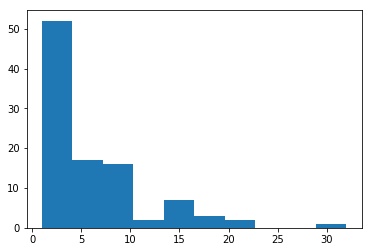

In [4]:
plt.hist(gamma)

In [5]:
params= {
    'kappa': [kappa],
    'lambda': [lam],
    'gains': [g],
    'rates':[1/gamma],
    'population':[n],
    'beta':[beta],
    'phi': [phi],
    'invariant': [V0],
    'dust' : [dust]}

In [6]:
initial_conditions = {'holdings': h,
                      'tokens': s0,
                      'supply': S0,
                      'prices': phat0,
                      'funds':F0,
                      'reserve': R0,
                      'spot_price': P0,
                      'actions': {}}

In [7]:
initial_conditions

{'holdings': array([1491.55435956,  220.27578262, 1427.61302781, 1837.26575481,
         213.40532294,  381.03687516, 1601.51537288, 4813.1662553 ,
        1868.79910159, 1138.68223172,  876.96458284, 1451.66010493,
         637.15523644,  722.52620083, 2986.72943671, 1696.36022861,
        2248.03302654,  171.33668465, 1046.16247899,  163.91100293,
         321.57265953, 1539.95340377, 1150.6561499 , 2017.809995  ,
         810.22492366,  356.85382975,  255.57699567, 2735.3029003 ,
         166.05187014,  553.87163738,  191.31958362,  245.15748154,
        1672.53699603,  429.85070433, 1821.52869909, 1275.30989826,
         376.89993344, 1044.730325  ,  357.60647402, 1201.64973791,
         401.07895237, 3332.56229971,  890.00829058,  218.79592259,
        3540.38718226,  321.26611676,  102.27640047,  320.05752999,
         422.18337838, 1937.20770684,  836.56389561,  813.00152219,
        1595.59377871, 1802.87939861,  900.46679522,  871.38716144,
         582.32788667,  537.83845232

In [8]:
#change in F (revenue and spending accounted for)
def revenue_process(params, step, sL, s):
    lam = params['lambda']
    rv = sts.expon.rvs(loc = 0, scale=1/lam)
    delF= 1-1/lam+rv
    
    #avoid the crash (temporary hacks, tune martingale process better)
    #if delF <1:
    #    if s['funds'] <1000:
    #        delF =100
    
    return({'delF':delF})

In [9]:
def update_funds(params, step, sL, s, _input):
    
    funds = s['funds']*_input['delF']
    
    key = 'funds'
    value = funds
    
    return (key, value)

In [10]:
def update_prices(params, step, sL, s, _input):
    
    g = params['gains']
    phat = g*s['funds']/s['supply']
    
    key = 'prices'
    value = phat
    
    return (key, value)

In [11]:
#change in F (revenue and spending accounted for)
def choose_agents(params, step, sL, s):
    n = params['population']
    rates = params['rates']
    
    agents = []
    for a in range(n):
        sq_gap = (s['spot_price']-s['prices'][a])**2
        pr = (rates[a]+sq_gap)/(1+sq_gap) #rates when sq_gap =0, 1 when sq_gap -> infty
        rv = np.random.rand()
        if rv < pr:
            agents.append(a)
    
    #shuffle
    shuffled_agents =np.random.choice(agents,len(agents), False)     
        
    return({'agents':shuffled_agents})

In [12]:
def agent_actions(params, step, sL, s, _input):
    
    R = s['reserve']
    S = s['supply']
    F = s['funds']
    V0 = params['invariant']
    P=s['spot_price']
    
    actions = []
    for a in _input['agents']:
        h_a = s['holdings'][a]
        phat_a = s['prices'][a]
        s_a =  s['tokens'][a]
        beta = params['beta']

        if P>phat_a: #equiv: pbar(0)>phat_a
            mech = 'burn'
                        
            #approx for burn s.t. p=phat
            #armijo style
            amt = s_a
            
            def pbar(amt):
                output = withdraw_with_tax(amt, R,S, V0, params['phi'], params['kappa'])

                if not(output[2])>0:
                    return np.Infinity
                else:
                    return output[2]

            if amt > 10**-8:
                while pbar(amt)< phat_a:
                    amt = amt*beta

        else: # P<phat_a; #equiv pbar(0)<phat_a
            mech = 'bond'
            #approx for buy s.t. p=phat
            #armijo style
            amt = h_a
  
            def pbar(amt):
                output = mint(amt, R,S, V0, params['kappa'])

                if not(output[1])>0:
                    return 0
                else:
                    return output[1]
                
            if amt > params['dust']:
                while pbar(amt)> phat_a:
                    amt = amt*beta
        
        action = {'agent':a, 'mech':mech, 'amt':amt, 'pbar':pbar(amt),'posterior':{}}
        
        if action['mech'] == 'bond':
            h_a = h_a-amt
            dS, pbar = mint(amt, R,S, V0, params['kappa'])
            R = R+amt
            S = S+dS
            s_a = s_a+dS
            P = spot_price(R, V0, kappa)
    
        elif action['mech'] == 'burn':
            s_a = s_a-amt
            dR, pbar = withdraw(amt, R,S, V0, params['kappa'])
            R = R-dR
            F = F + params['phi']*dR
            S = S-amt
            h_a = h_a + (1-params['phi'])*dR
            P = spot_price(R, V0, kappa)
        
        action['posterior'] = {'F':F, 'S':S, 'R':R,'P':P, 'a':a,'s_a':s_a, 'h_a':h_a}
        actions.append(action)
        
    key = 'actions'
    value = actions
    
    return (key, value)

In [13]:
def resolve_actions(params, step, sL, s):
    
    H_a = s['holdings']
    S_a =  s['tokens']
    
    actions = s['actions']
    
    for action in actions:
        a= action['agent']
        H_a[a] = action['posterior']['h_a']
        S_a[a] = action['posterior']['s_a']
    
    #last action only
    F = action['posterior']['F']
    R = action['posterior']['R']
    P = action['posterior']['P']
    S = action['posterior']['S']
    
    return({'F':F, 'S':S, 'R':R,'P':P, 'S_a':S_a, 'H_a':H_a})

In [14]:
def update_F(params, step, sL, s, _input):
    
    F = _input['F']
    
    key = 'funds'
    value = F
    
    return (key, value)

def update_S(params, step, sL, s, _input):
    
    S = _input['S']
    
    key = 'supply'
    value = S
    
    return (key, value)

def update_R(params, step, sL, s, _input):
    
    R = _input['R']
    
    key = 'reserve'
    value = R
    
    return (key, value)

def update_P(params, step, sL, s, _input):
    
    P = _input['P']
    
    key = 'spot_price'
    value = P
    
    return (key, value)

def update_holdings(params, step, sL, s, _input):
    
    H_a = _input['H_a']
    
    key = 'holdings'
    value = H_a
    
    return (key, value)

def update_tokens(params, step, sL, s, _input):
    
    S_a = _input['S_a']
    
    sumS = np.sum(S_a)
    S = _input['S']
    
    tokens = S_a*S/sumS
    
    key = 'tokens'
    value = tokens
    
    return (key, value)

In [15]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The Partial State Update Blocks
partial_state_update_blocks = [
    { 
        'policies': { 
            #new proposals or new participants
            'random': revenue_process
        },
        'variables': {
            'funds': update_funds,
            'prices': update_prices
        }
    },
    {
      'policies': {
          'random': choose_agents
        },
        'variables': { 
            'actions': agent_actions, 
        }
    },
    {
      'policies': {
          'act': resolve_actions,
        },
        'variables': {
            'funds': update_F, #
            'supply': update_S, 
            'reserve': update_R,
            'spot_price': update_P,
            'holdings': update_holdings,
            'tokens': update_tokens
        }
    }
]

In [16]:
time_periods_per_run = 5000
monte_carlo_runs = 1

from cadCAD.configuration.utils import config_sim
simulation_parameters = config_sim({
    'T': range(time_periods_per_run),
    'N': monte_carlo_runs,
    'M': params
})

In [17]:
from cadCAD.configuration import append_configs
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# The configurations above are then packaged into a `Configuration` object
append_configs(
    initial_state=initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters #dict containing simulation parameters
)

[{'N': 1, 'T': range(0, 5000), 'M': {'kappa': 2, 'lambda': 200, 'gains': array([0.73367846, 2.71691057, 1.41076956, 1.42891825, 1.49114154,
       2.10822977, 1.65132761, 2.07042345, 1.40897136, 2.38005052,
       2.10776616, 2.3365585 , 0.97435478, 2.10455653, 1.79339891,
       1.26850517, 2.02490894, 2.54562971, 2.3738383 , 1.3843783 ,
       1.59104031, 2.32817395, 2.55281667, 1.90447954, 1.62745615,
       2.07041234, 1.8773729 , 1.85946406, 1.38273899, 2.33587529,
       2.23491101, 1.73925407, 0.97499668, 2.74982515, 1.84167486,
       1.95494333, 1.96444055, 1.72181825, 2.87185532, 2.07489349,
       2.19640108, 2.749915  , 2.01349133, 2.08746513, 1.1728389 ,
       1.08507175, 0.36766485, 1.55562008, 2.01184819, 2.16828692,
       1.24374517, 1.3184594 , 2.56691333, 1.65401685, 2.22761044,
       1.82719782, 2.10570537, 1.66020692, 2.534708  , 1.98679766,
       2.24308303, 1.52596016, 1.85151643, 1.9912393 , 2.35033616,
       2.12895337, 2.86978766, 1.72353564, 2.04636656, 2

In [18]:
from tabulate import tabulate
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs
import pandas as pd

exec_mode = ExecutionMode()
multi_proc_ctx = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=multi_proc_ctx, configs=configs)

In [19]:
i = 0
verbose = False
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    if verbose:
        print()
        print(f"Tensor Field: {type(tensor_field)}")
        print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
        print(f"Output: {type(result)}")
        print(tabulate(result, headers='keys', tablefmt='psql'))
        print()
    results[i] = {}
    results[i]['result'] = result
    results[i]['simulation_parameters'] = simulation_parameters[i]
    i += 1
    


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x1a15f4b0f0>]
Configurations: [<cadCAD.configuration.Configuration object at 0x1a15f4b0f0>]


/Users/Zargham/Documents/GitHub/conviction/bonding_curve_eq.py:62: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = quantity_recieved/deltaS
/Users/Zargham/Documents/GitHub/conviction/bonding_curve_eq.py:62: RuntimeWarning: divide by zero encountered in double_scalars
  realized_price = quantity_recieved/deltaS


In [20]:
experiment_index = 0
df = results[experiment_index]['result']

In [21]:
df.head()

,actions,funds,holdings,prices,reserve,run,spot_price,substep,supply,timestep,tokens
0,{},50000.000000,"[1491.554359556692, 220.2757826216507, 1427.61...","[0.036683923187958434, 0.13584552866350832, 0....",50000.000000,1,0.100000,0,1.000000e+06,0,"[12303.538067007707, 10109.380395456104, 10926..."
1,{},49751.511718,"[1491.554359556692, 220.2757826216507, 1427.61...","[0.036683923187958434, 0.13584552866350832, 0....",50000.000000,1,0.100000,1,1.000000e+06,1,"[12303.538067007707, 10109.380395456104, 10926..."
2,"[{'agent': 12, 'mech': 'burn', 'amt': 5529.016...",49751.511718,"[1491.554359556692, 220.2757826216507, 1427.61...","[0.036683923187958434, 0.13584552866350832, 0....",50000.000000,1,0.100000,2,1.000000e+06,1,"[12303.538067007707, 10109.380395456104, 10926..."
3,"[{'agent': 12, 'mech': 'burn', 'amt': 5529.016...",50431.256076,"[1491.554359556692, 0.0, 1427.6130278081594, 1...","[0.036683923187958434, 0.13584552866350832, 0....",56392.984066,1,0.106201,3,1.062007e+06,1,"[12303.538067007703, 12185.555300491747, 10926..."
4,"[{'agent': 12, 'mech': 'burn', 'amt': 5529.016...",50251.729410,"[1491.554359556692, 0.0, 1427.6130278081594, 1...","[0.03483998989031369, 0.12901719429056374, 0.0...",56392.984066,1,0.106201,1,1.062007e+06,2,"[12303.538067007703, 12185.555300491747, 10926..."


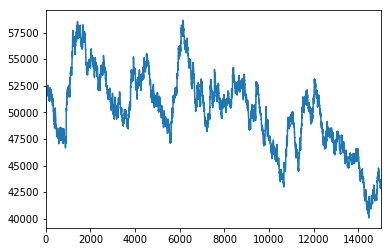

In [22]:
df.funds.plot()

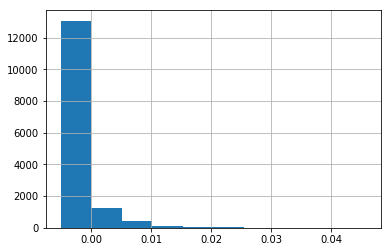

In [23]:
(df.funds.diff()/df.funds).hist()

In [24]:
rdf = df[df.substep == 3].copy()

In [25]:
rdf['token_wts'] = (rdf.tokens/rdf.supply)
rdf['wt_mean_price'] = (rdf.token_wts*rdf.prices).apply(sum)

In [26]:
rdf['holding_wts'] = (rdf.holdings/rdf.holdings.apply(sum))
rdf['h_wt_mean_price'] = (rdf.holding_wts*rdf.prices).apply(sum)

In [27]:
rdf['wealth'] = rdf.holdings + rdf.spot_price*rdf.tokens

In [28]:
rdf['wealth_wts'] = rdf.wealth/rdf.wealth.apply(sum)
rdf['w_wt_mean_price'] = (rdf.wealth_wts*rdf.prices).apply(sum)

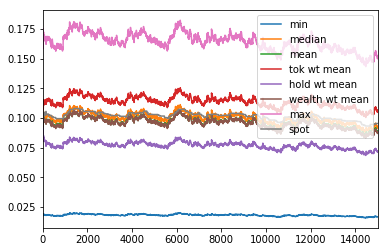

In [29]:
rdf.prices.apply(np.min).plot()
rdf.prices.apply(np.median).plot()
rdf.prices.apply(np.mean).plot()
rdf.wt_mean_price.plot()
rdf.h_wt_mean_price.plot()
rdf.w_wt_mean_price.plot()
rdf.prices.apply(np.max).plot()
rdf.spot_price.plot()
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

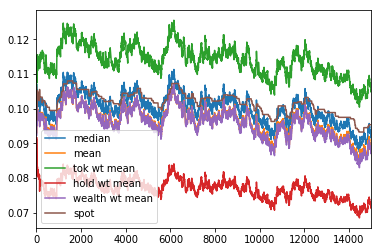

In [30]:
rdf.prices.apply(np.median).plot()
rdf.prices.apply(np.mean).plot()
rdf.wt_mean_price.plot()
rdf.h_wt_mean_price.plot()
rdf.w_wt_mean_price.plot()
rdf.spot_price.plot()
plt.legend(['median','mean','tok wt mean','hold wt mean','wealth wt mean', 'spot'])

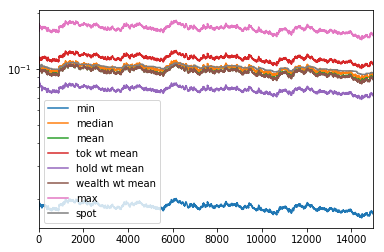

In [31]:
rdf.prices.apply(np.min).plot(logy=True)
rdf.prices.apply(np.median).plot(logy=True)
rdf.prices.apply(np.mean).plot(logy=True)
rdf.wt_mean_price.plot(logy=True)
rdf.h_wt_mean_price.plot(logy=True)
rdf.w_wt_mean_price.plot(logy=True)
rdf.prices.apply(np.max).plot(logy=True)
rdf.spot_price.plot(logy=True)
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

In [32]:
rdf['median_price']=rdf.prices.apply(np.median)
rdf['mean_price']=rdf.prices.apply(np.mean)

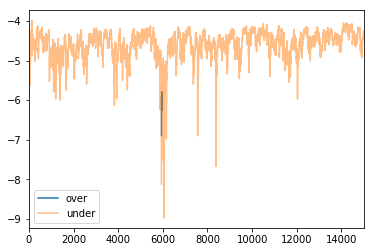

In [33]:
(np.sign(rdf['mean_price']-rdf['spot_price'])*(rdf['mean_price']-rdf['spot_price'])**2).apply(np.log10).plot(alpha=1)
(-np.sign(rdf['mean_price']-rdf['spot_price'])*(rdf['mean_price']-rdf['spot_price'])**2).apply(np.log10).plot(alpha=.5)
plt.legend(['over','under'])

In [34]:
rdf['est_err'] = rdf.spot_price - rdf.wt_mean_price
rdf['sq_est_err'] = rdf['est_err']**2

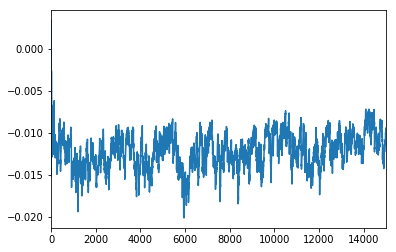

In [35]:
rdf.est_err.plot()

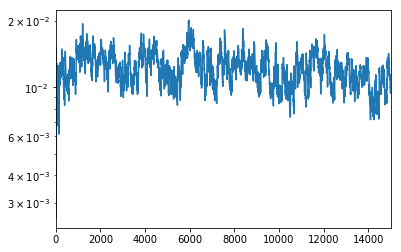

In [36]:
rdf.est_err.apply(np.abs).plot(logy=True)

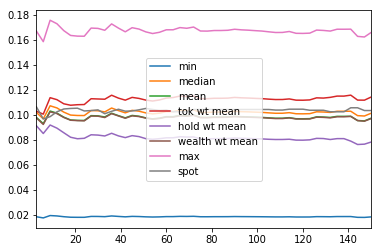

In [37]:
#head T
T = 50
rdf.head(T).prices.apply(np.min).plot()
rdf.head(T).prices.apply(np.median).plot()
rdf.head(T).prices.apply(np.mean).plot()
rdf.head(T).wt_mean_price.plot()
rdf.head(T).h_wt_mean_price.plot()
rdf.head(T).w_wt_mean_price.plot()
rdf.head(T).prices.apply(np.max).plot()
rdf.head(T).spot_price.plot()
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

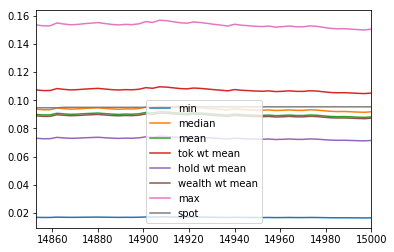

In [38]:
T = 50
rdf.tail(T).prices.apply(np.min).plot()
rdf.tail(T).prices.apply(np.median).plot()
rdf.tail(T).prices.apply(np.mean).plot()
rdf.tail(T).wt_mean_price.plot()
rdf.tail(T).h_wt_mean_price.plot()
rdf.tail(T).w_wt_mean_price.plot()
rdf.tail(T).prices.apply(np.max).plot()
rdf.tail(T).spot_price.plot()
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

In [39]:
tx_data = rdf.actions.values
transactions = []
states = []
for t in range(time_periods_per_run):
    for tx in range(len(tx_data[t])):
        states.append(tx_data[t][tx]['posterior'])
        transactions.append(tx_data[t][tx])


In [40]:
sdf = pd.DataFrame(states)
tdf = pd.DataFrame(transactions).drop('posterior', axis=1)

In [41]:
ind=tdf[tdf.amt==0].index
tdf.drop(ind, inplace=True)
sdf.drop(ind, inplace=True)

In [42]:
txdf = sdf.merge(tdf, right_index=True, left_index=True)

In [43]:
txdf.head()

,F,P,R,S,a,h_a,s_a,agent,amt,mech,pbar
0,49779.080375,0.099447,49448.626857,9.944710e+05,12,1160.959722,0.000000,12,5529.016438,burn,0.094737
1,49779.080375,0.101683,51696.659884,1.016825e+06,16,0.000000,34521.950292,16,2248.033027,bond,0.100565
2,49840.696699,0.100463,50464.333403,1.004633e+06,53,2973.589556,0.000000,53,12192.454040,burn,0.096019
3,49840.696699,0.101391,51400.540725,1.013909e+06,73,0.000000,16015.739280,73,936.207322,bond,0.100927
4,49840.696699,0.101548,51559.501281,1.015475e+06,70,0.000000,9251.317400,70,158.960556,bond,0.101469


In [44]:
emas = ['P', 'pbar']
for com in [2,4,8,16]:
    k = 'pbar_ewma'+str(com)
    emas.append(k)
    txdf[k] = txdf.pbar.ewm(com).mean()

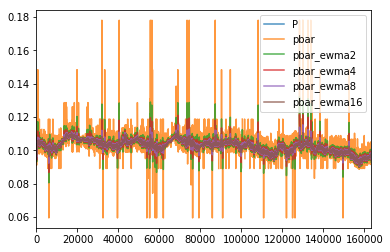

In [45]:
txdf[emas].plot(alpha=.8)

[0, 3000, 0.095, 0.115]

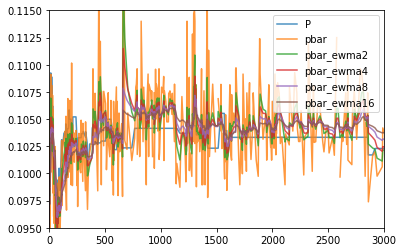

In [46]:
txdf[emas].plot(alpha=.8)
plt.axis([0, 3000, .095, .115])

In [47]:
txdf['dP'] = txdf.P.diff()
txdf['percent_dP'] = txdf.P.pct_change().apply(abs)

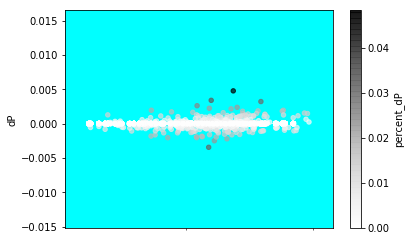

In [48]:
txdf.plot.scatter(x='R', y='dP', c='percent_dP', alpha=.7, logx=True)
plt.gca().set_facecolor('cyan') 

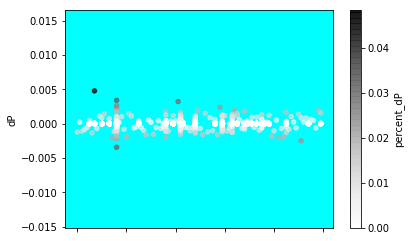

In [49]:
txdf.plot.scatter(x='a',y='dP', c='percent_dP', alpha=.7)
plt.gca().set_facecolor('cyan') 

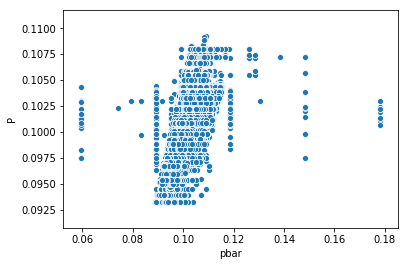

In [50]:
sns.scatterplot(x="pbar", y="P", data=txdf) 

ValueError: Axis limits cannot be NaN or Inf

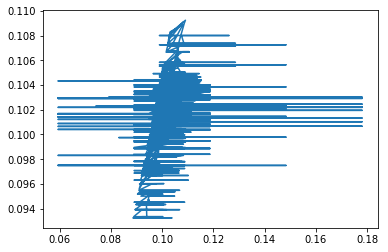

In [51]:
txdf.plot(x='pbar',y='P')

In [ ]:
sns.jointplot(x="pbar", y="P",kind="reg", data=txdf.replace([np.inf, -np.inf], np.nan).dropna(how="all")) 

In [ ]:
txdf['P_err'] = txdf.P-txdf.pbar

In [ ]:
sns.jointplot(x="agent", y="P_err",kind="reg", data=txdf.replace([np.inf, -np.inf], np.nan).dropna(how="all")) 

In [ ]:
sns.jointplot(x='index',y="P",kind="reg", data=txdf.replace([np.inf, -np.inf], np.nan).dropna(how="all").reset_index()) 

In [ ]:
sns.scatterplot(x='index',y="P_err", hue = "pbar", data=txdf.replace([np.inf, -np.inf], np.nan).dropna(how="all").reset_index()) 

In [ ]:
sns.scatterplot(x='index',y="P", hue = "pbar", data=txdf.replace([np.inf, -np.inf], np.nan).dropna(how="all").reset_index()) 

In [ ]:
txdf['P_err_factor'] = txdf.P/txdf.pbar

In [ ]:
sns.scatterplot(x='index',y="P_err_factor", hue = "pbar", data=txdf.replace([np.inf, -np.inf], np.nan).dropna(how="all").reset_index()) 
plt.gca().set_yscale('log')

In [ ]:
tx_summary=tdf[['agent','mech','pbar','amt']].groupby(['agent','mech']).agg(['median','count']).T.iloc[:-1].T

In [ ]:
tx_summary

In [ ]:
tx_summary.pbar['median'].plot()

In [ ]:
sdf['P'].plot(logx=True)

In [ ]:
sdf['P'].plot()

In [ ]:
sdf.F.plot()

In [ ]:
bond_amts = [tdf.iloc[k].amt for k in range(time_periods_per_run) if tdf.iloc[k].mech=='bond']
burn_amts = [tdf.iloc[k].amt for k in range(time_periods_per_run) if tdf.iloc[k].mech=='burn']

In [ ]:
plt.hist(bond_amts, bins=20)
plt.yscale('log')

In [ ]:
plt.hist(burn_amts, bins=20)
plt.yscale('log')

In [ ]:
rdf['invariant'] = rdf.supply.apply(lambda x: x**kappa)/rdf.reserve

In [ ]:
rdf.plot(x='reserve', y='supply', kind='scatter', alpha=.5)
axis = plt.axis()
xrange = np.arange(axis[0], axis[1], (axis[1]-axis[0])/100)
yrange = np.array([supply(x, V0, kappa) for x in xrange ])
plt.plot(xrange, yrange, 'y')
plt.title('Bonding Curve Invariant')
plt.legend(['Invariant', 'Observed Data'])

In [ ]:
def gini(x):

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [ ]:
plt.hist(rdf.iloc[-1].holdings)

In [ ]:
rdf['gini_h'] = rdf.holdings.apply(gini)

In [ ]:
rdf.gini_h.plot()

In [ ]:
plt.hist(rdf.iloc[-1].tokens)

In [ ]:
rdf['gini_s'] = rdf.tokens.apply(gini)

In [ ]:
rdf.gini_s.plot()

In [ ]:
rdf.tokens.apply(np.count_nonzero).plot()

In [ ]:
rdf['asset_value'] = rdf.holdings + rdf.spot_price*rdf.tokens

In [ ]:
plt.hist(rdf.iloc[-1].asset_value)

In [ ]:
rdf['gini'] = rdf.asset_value.apply(gini)

In [ ]:
rdf.gini.plot()

In [ ]:
rdf['pref_gap'] = (rdf.prices - rdf.spot_price)/rdf.spot_price

In [ ]:
plt.hist(rdf.iloc[-7:].pref_gap, bins=7)
plt.show()